In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as tgrad
from torch.autograd import Variable

import os
import time
import utils
import numpy as np

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import networks
import importlib

In [20]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
seed = 1234
torch.set_default_dtype(torch.float32)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# Data Sampling
Here in our case, the system is European Call Option PDE and the physical information about the system consists of Boundary Value conditions, final Value conditions and the PDE itself.

In [21]:
K = 10
r = 0.035
sigma = 0.2
T = 1
S_range = [0, int(5*K)]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
M = 100
N = 5000

# Build Neural Network

In [22]:
net = networks.FeedforwardNeuralNetwork(2, 50, 1, 8) #  Network initialization
net.cuda()

FeedforwardNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-7): 7 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

In [23]:
n_epochs = 5000
lossFunction = nn.MSELoss()
lr = 3e-5
optimizer = optim.Adam(net.parameters(), lr=lr)

x_f_s = torch.tensor(0.).float().to(device).requires_grad_(True)
x_label_s = torch.tensor(0.).float().to(device).requires_grad_(True)
x_data_s = torch.tensor(0.).float().to(device).requires_grad_(True)
optimizer_adam_weight = torch.optim.Adam([x_f_s] + [x_label_s] + [x_data_s], lr=lr*0.1)

In [24]:
# physical loss samples
samples = {"pde": 5000, "bc":500, "fc":500}

# sample data generated by finite difference method
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = utils.fdm_data(S_range[-1], T, M, N, "500000sample.csv", device)

# lr * 100 does not work well
# lr * 10 learn faster when loss is high:   1104.61633,  60.94701, 11.68325, 0.69711, 0.01023, 0.00671 ... 0.00338
# lr * 1 is generally better:               1104.61633, 55.42899, 11.53931, 0.81472, 0.01160, 0.00810 ... 0.00440
# lr * 0.1 is generally better:             

# Modelling


In [25]:
loss_hist = []
start_time = time.time()

for epoch in range(n_epochs):
    
    bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, r, sigma, T, S_range[-1], S_range, t_range, gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)
    
    # save training data points to tensor and send to device
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(n_v_train).float().to(device)
    
    bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
    bc_v_train = torch.from_numpy(bc_v_train).float().to(device)   
    
    # pde residual loss
    y1_hat = net(n_st_train)
    grads = tgrad.grad(y1_hat, n_st_train, grad_outputs=torch.ones(y1_hat.shape).cuda(), 
                retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(), 
                    create_graph=True, only_inputs=True, allow_unused=True)[0]
    S1 = n_st_train[:, 1].view(-1, 1)
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)
    
    # boudary condition loss
    y2_hat = net(bc_st_train)
    bc_loss = lossFunction(bc_v_train, y2_hat)
    
    # sample training data loss
    y3_hat = net(X_train_tensor)
    data_loss = lossFunction(y_train_tensor, y3_hat)
    
    # Backpropagation and Update
    optimizer.zero_grad()
    combined_loss = torch.exp(-x_f_s.detach()) * pde_loss + torch.exp(-x_label_s.detach()) * bc_loss + torch.exp(-x_data_s.detach()) * data_loss + x_data_s + x_label_s + x_f_s
    combined_loss.backward()
    optimizer.step()
    
    # update the weight
    optimizer_adam_weight.zero_grad()
    loss = torch.exp(-x_f_s) * pde_loss.detach() + torch.exp(-x_label_s) * bc_loss.detach() + torch.exp(-x_data_s) * data_loss.detach() + x_data_s + x_label_s + x_f_s
    loss.backward()
    optimizer_adam_weight.step()
    
    # record the loss
    mse_loss = pde_loss + bc_loss + data_loss
    loss_hist.append(mse_loss.item())
    if epoch % 500 == 0:
        print(f'{epoch}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, data loss: {data_loss.item():.5f}, total loss: {mse_loss.item():.5f}, minimum loss: {min(loss_hist):.5f}')
        print(f'the weight is {torch.exp(-x_f_s.detach()).item():.5f}, {torch.exp(-x_label_s.detach()).item():.5f}. {torch.exp(-x_data_s.detach()).item():.5f}, the parameter is {x_f_s.item():.5f}, {x_label_s.item():.5f}, {x_data_s.item():.5f}')
    pass

end_time = time.time()

print('run time:', end_time - start_time)
print('Adam done!')

0/5000 PDE Loss: 0.00001, BC Loss: 677.80835, data loss: 426.80795, total loss: 1104.61633, minimum loss: 1104.61633
the weight is 1.00003, 0.99997. 0.99997, the parameter is -0.00003, 0.00003, 0.00003
500/5000 PDE Loss: 0.00078, BC Loss: 35.56202, data loss: 19.86619, total loss: 55.42899, minimum loss: 55.42899
the weight is 1.01514, 0.98765. 0.98779, the parameter is -0.01503, 0.01243, 0.01228
1000/5000 PDE Loss: 0.17622, BC Loss: 3.79465, data loss: 7.56843, total loss: 11.53931, minimum loss: 11.53931
the weight is 1.02987, 0.98743. 0.98721, the parameter is -0.02943, 0.01265, 0.01287
1500/5000 PDE Loss: 0.18214, BC Loss: 0.18861, data loss: 0.44397, total loss: 0.81472, minimum loss: 0.81472
the weight is 1.04189, 0.98741. 0.98703, the parameter is -0.04103, 0.01267, 0.01305
2000/5000 PDE Loss: 0.00814, BC Loss: 0.00170, data loss: 0.00175, total loss: 0.01160, minimum loss: 0.01160
the weight is 1.05920, 0.98748. 0.98714, the parameter is -0.05751, 0.01260, 0.01294
2500/5000 PDE

Text(0.5, 1.0, 'AWPINN loss')

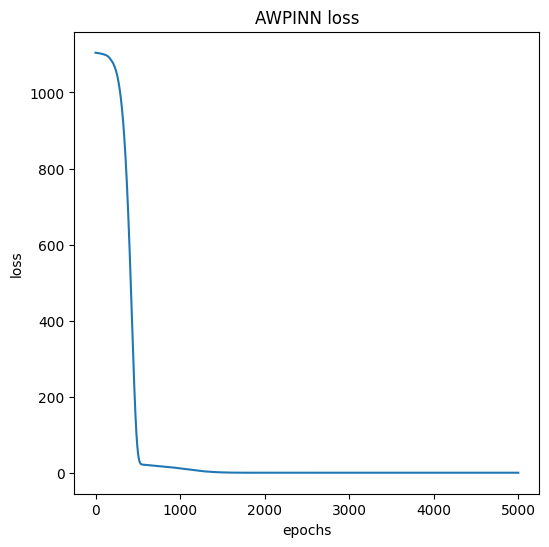

In [26]:
fig = plt.figure(figsize=(6,6))
plt.plot(range(n_epochs), loss_hist)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('AWPINN loss')

In [27]:
# Evaluate the model on the test set
net.eval()
with torch.no_grad():
    test_outputs = net(X_test_tensor)
    test_loss = lossFunction(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0015
